In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.compose import TransformedTargetRegressor
#sklearn transformer
from sklearn.preprocessing import QuantileTransformer as qtTrans
from sklearn import preprocessing

#libraries for statistical analysis of series
from statsmodels.tsa.stattools import adfuller

In [2]:
#import data set into a pandas dataframe
dataframe=pd.read_csv('salesdaily.csv',usecols=['datum','M01AB']).dropna()
dataframe.head()

,datum,M01AB
0,1/2/2014,0.0
1,1/3/2014,8.0
2,1/4/2014,2.0
3,1/5/2014,4.0
4,1/6/2014,5.0


In [3]:
#starting the time series
dataframe['datum']=pd.to_datetime(dataframe['datum'])
date_index_df=dataframe.set_index(['datum'])
date_index_df.head(4)

,M01AB
datum,
2014-01-02,0.0
2014-01-03,8.0
2014-01-04,2.0
2014-01-05,4.0


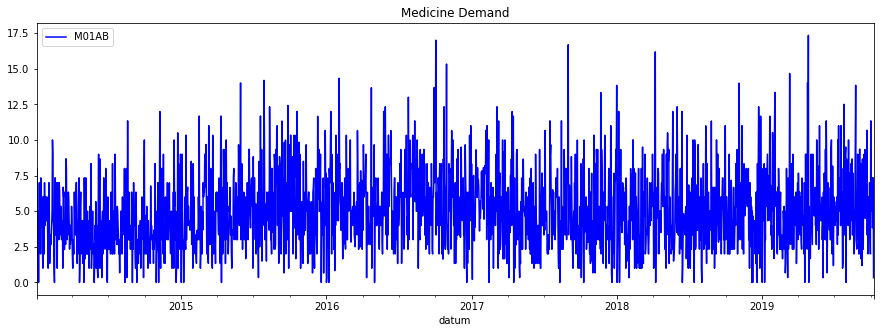

In [4]:
date_index_df.plot(style='-',figsize=(15,5),color='blue',title='Medicine Demand')
plt.show()

In [5]:
#split the data into train and test sets - 30% split
train_data=date_index_df.loc[date_index_df.index<'06-01-2018']
test_data=date_index_df.loc[date_index_df.index>='06-01-2018']

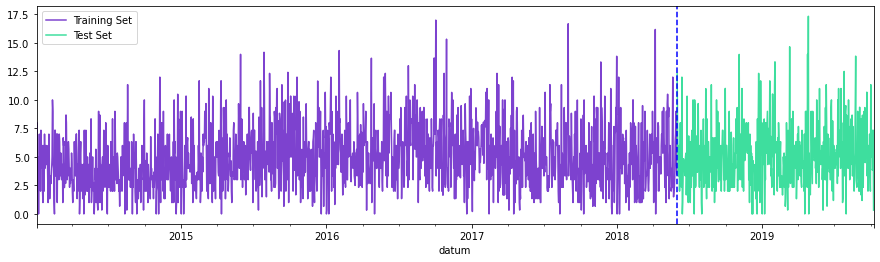

In [7]:
fig,ax=plt.subplots(figsize=(15,4))
train_data.plot(ax=ax, label='Train Set',color='#7d42cf')
test_data.plot(ax=ax, label='Test Set',color='#3ede9e')
ax.axvline('06-01-2018',color='blue',ls='--')
ax.legend(['Training Set','Test Set'])
plt.show()

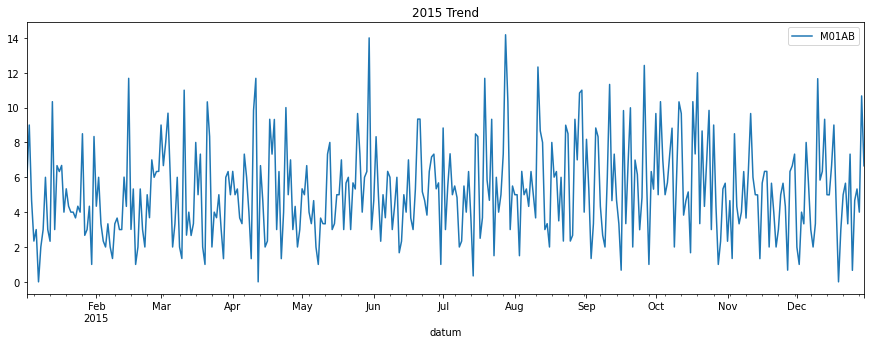

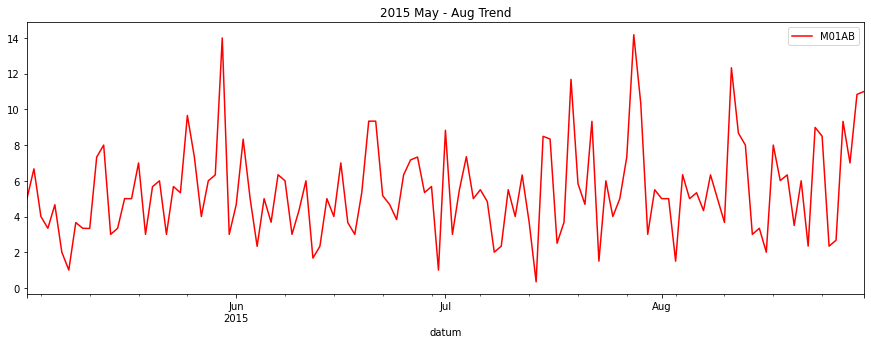

In [8]:
#looking at the trend in the first year - 2015
date_index_df.loc[(date_index_df.index>'01-01-2015')&(date_index_df.index<'12-31-2015')].plot(figsize=(15,5),title='2015 Trend')
date_index_df.loc[(date_index_df.index>'05-01-2015')&(date_index_df.index<'8-31-2015')].plot(figsize=(15,5),title='2015 May - Aug Trend',color='red')
plt.show()

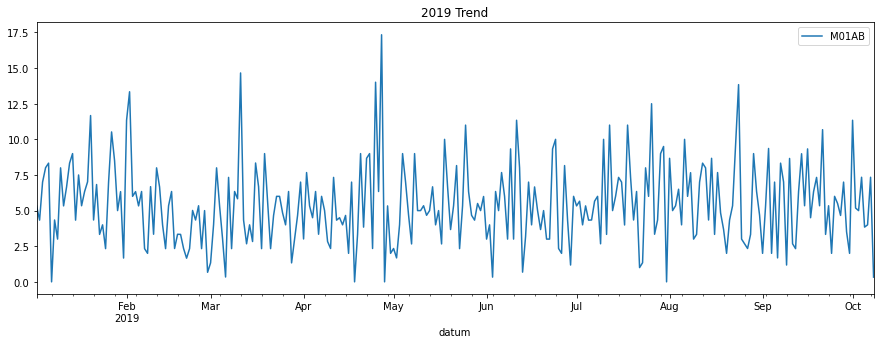

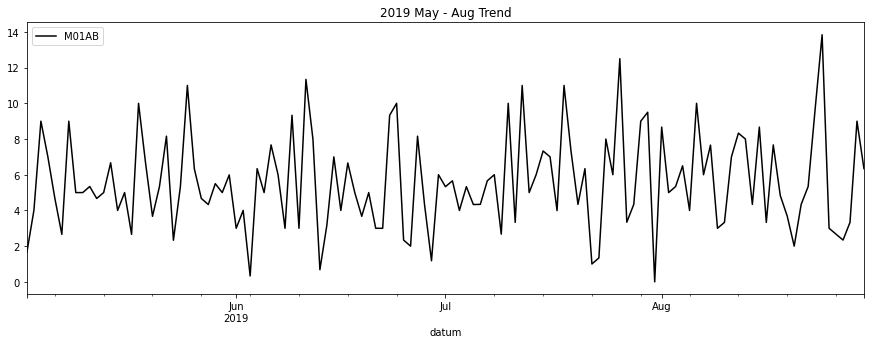

In [9]:
#looking at the trend in the first year - 2015
date_index_df.loc[(date_index_df.index>'01-01-2019')&(date_index_df.index<'12-31-2019')].plot(figsize=(15,5),title='2019 Trend')
date_index_df.loc[(date_index_df.index>'05-01-2019')&(date_index_df.index<'8-31-2019')].plot(figsize=(15,5),title='2019 May - Aug Trend',color='black')
plt.show()

In [10]:
#checking for the data stationality
#get the rolling mean
roll_mean=date_index_df.rolling(window=12).mean() #12 months
roll_std=date_index_df.rolling(window=12).std()

print(f'Rolling Mean: {roll_mean}, Rolling Standard Deviation: {roll_std}')

Rolling Mean:                M01AB
datum               
2014-01-02       NaN
2014-01-03       NaN
2014-01-04       NaN
2014-01-05       NaN
2014-01-06       NaN
...              ...
2019-10-04  5.405833
2019-10-05  5.280833
2019-10-06  5.447500
2019-10-07  5.559167
2019-10-08  5.128333

[2106 rows x 1 columns], Rolling Standard Deviation:                M01AB
datum               
2014-01-02       NaN
2014-01-03       NaN
2014-01-04       NaN
2014-01-05       NaN
2014-01-06       NaN
...              ...
2019-10-04  2.512306
2019-10-05  2.552868
2019-10-06  2.378537
2019-10-07  2.437556
2019-10-08  2.867875

[2106 rows x 1 columns]


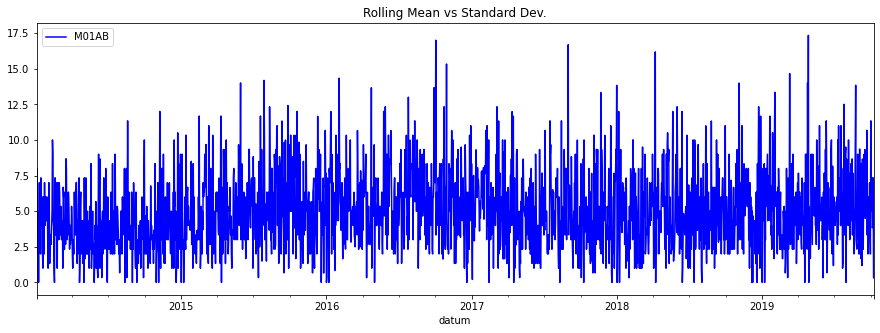

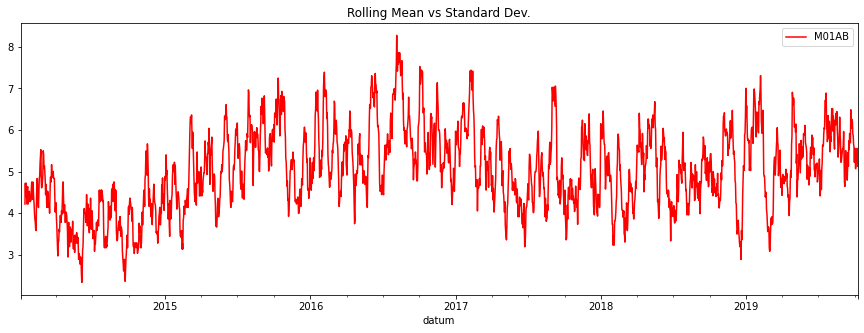

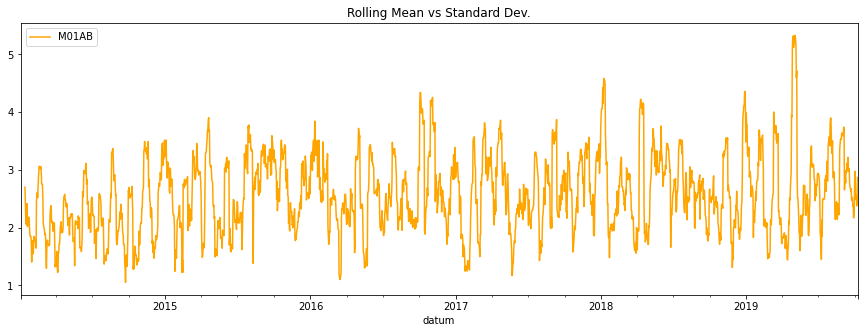

In [11]:
#plotting our rolling mean
original=date_index_df.plot(style='-',figsize=(15,5),color='blue',title='Rolling Mean vs Standard Dev.')
mean=roll_mean.plot(style='-',figsize=(15,5),color='red',title='Rolling Mean vs Standard Dev.',legend='Rolling Mean')
std_dev=roll_std.plot(style='-',figsize=(15,5),color='orange',title='Rolling Mean vs Standard Dev.',legend='Rolling Standard Deviation')
plt.show()

In [12]:
# Dickey-Fuller tests
print(f'Results of out Dickey-Fuller Test:')
test=adfuller(date_index_df['M01AB'], autolag='AIC')
output=pd.Series(test[0:4], index=['Test Statistics','p-value','Lags Used','Observations Used'])

for k,v in test[4].items():
    output['Critical Value (%s)'%k]=v

#print output
output

Results of out Dickey-Fuller Test:


Test Statistics        -8.279357e+00
p-value                 4.563943e-13
Lags Used               1.400000e+01
Observations Used       2.091000e+03
Critical Value (1%)    -3.433481e+00
Critical Value (5%)    -2.862923e+00
Critical Value (10%)   -2.567506e+00
dtype: float64

In [13]:
#generating features
def feature_generator(dF):
    dF=dF.copy()
    dF['year']=dF.index.year#year
    dF['month']=dF.index.month #we get month from our datetime index
    dF['day']=dF.index.day
    
    return dF

In [14]:
df=feature_generator(date_index_df)
df.head()

,M01AB,year,month,day
datum,,,,
2014-01-02,0.0,2014,1,2
2014-01-03,8.0,2014,1,3
2014-01-04,2.0,2014,1,4
2014-01-05,4.0,2014,1,5
2014-01-06,5.0,2014,1,6


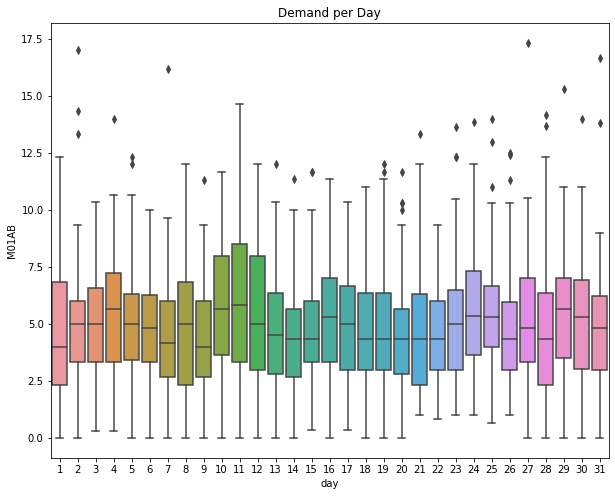

In [15]:
#purchase per day
fig,ax=plt.subplots(figsize=(10,8))
sns.boxplot(data=df,x='day',y='M01AB')
ax.set_title('Demand per Day')
plt.show()

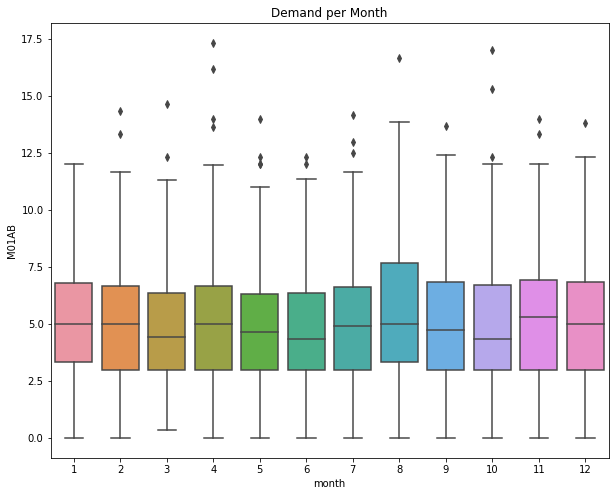

In [16]:
#purchase per month
fig,ax=plt.subplots(figsize=(10,8))
sns.boxplot(data=df,x='month',y='M01AB')
ax.set_title('Demand per Month')
plt.show()

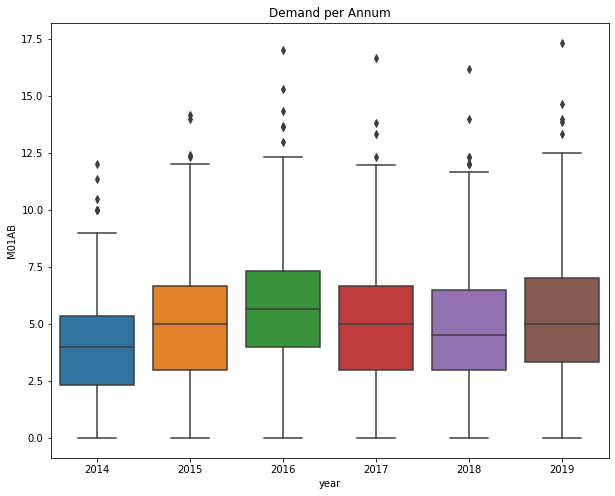

In [17]:
#purchase per year
fig,ax=plt.subplots(figsize=(10,8))
sns.boxplot(data=df,x='year',y='M01AB')
ax.set_title('Demand per Annum')
plt.show()

# Data Transformation

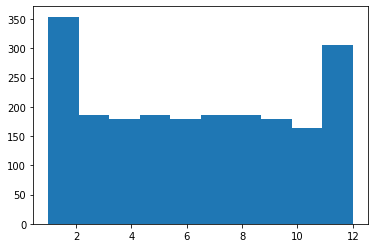

In [18]:
#data distibution

# We can set the number of bins with the *bins* keyword argument.
plt.hist(df['month'])
plt.show()


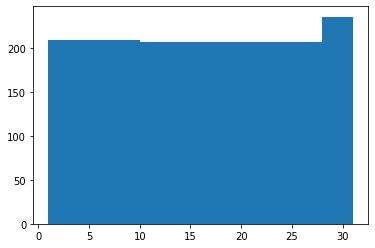

In [19]:
plt.hist(df['day'])
plt.show()

In [21]:
#transformers
transformer=qtTrans(output_distribution='normal')


In [22]:
#model development
#run train and test through features function to create features we are going to use
train_set=feature_generator(train_data)
test_set=feature_generator(test_data)
FEATURES=['year','month','day']
TARGET='M01AB'

In [23]:
X_train=train_set[FEATURES]
y_train=train_set[TARGET]

X_test=test_set[FEATURES]
y_test=test_set[TARGET]



In [59]:
#model
reg=xgb.XGBRegressor(n_estimators=1500, early_stopping_rounds=50)
regTransformed=TransformedTargetRegressor(regressor=reg,transformer=transformer)
regTransformed.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=100)

[0]	validation_0-rmse:5.35502	validation_1-rmse:5.57592
[49]	validation_0-rmse:5.50604	validation_1-rmse:5.95323


TransformedTargetRegressor(regressor=XGBRegressor(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  early_stopping_rounds=50,
                                                  enable_categorical=False,
                                                  eval_metric=None,
                                                  feature_types=None,
                                                  gamma=None, gpu_id=None,
                                                  grow_policy=None,
                                                  importance_type=None,
                                                  interaction_constraints=None,
                                                  learning_rate=None,
                                                  max_bin=None,
                                                  max_cat_threshold=None,
                                                  max_cat_to_onehot=None,
                                                  max_delta_step=None,
                                                  max_depth=None,
                                                  max_leaves=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  n_estimators=1500,
                                                  n_jobs=None,
                                                  num_parallel_tree=None,
                                                  predictor=None,
                                                  random_state=None, ...),
                           transformer=QuantileTransformer(output_distribution='normal'))

In [61]:
#prediction
test_data['prediction']=regTransformed.predict(X_test)
test_data['prediction'].fillna(value=test_data['prediction'].mean(),inplace=True)
test_data.head(5)

C:\Users\theop\AppData\Local\Temp\ipykernel_16400\1235172924.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction']=regTransformed.predict(X_test)
C:\Users\theop\AppData\Local\Temp\ipykernel_16400\1235172924.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction'].fillna(value=test_data['prediction'].mean(),inplace=True)


,M01AB,prediction
datum,,
2018-06-01,12.33,5.34
2018-06-02,8.00,6.00
2018-06-03,5.00,6.00
2018-06-04,3.33,6.00
2018-06-05,4.33,6.00


In [28]:
df=df.merge(test_data[['prediction']], how='left',left_index=True,right_index=True).dropna()

df

,M01AB,year,month,day,prediction
datum,,,,,
2018-06-01,12.33,2018,6,1,5.34
2018-06-02,8.00,2018,6,2,6.00
2018-06-03,5.00,2018,6,3,6.00
2018-06-04,3.33,2018,6,4,6.00
2018-06-05,4.33,2018,6,5,6.00
...,...,...,...,...,...
2019-10-04,7.34,2019,10,4,6.00
2019-10-05,3.84,2019,10,5,6.00
2019-10-06,4.00,2019,10,6,6.00


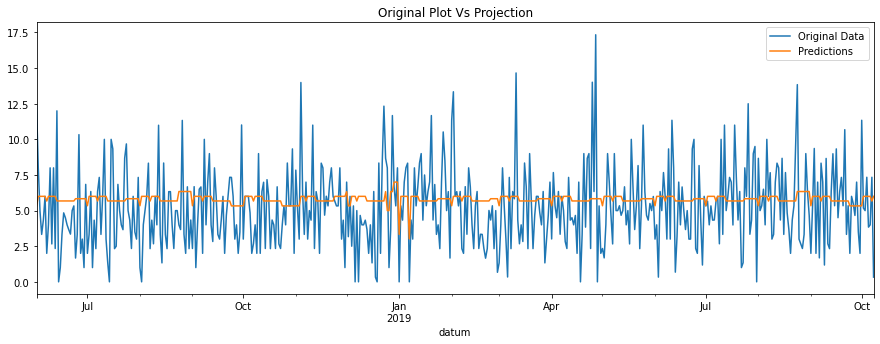

In [62]:
#plot the predictions made on original dat
ax=df['M01AB'].plot(figsize=(15,5))
df['prediction'].plot(ax=ax,style='-')
plt.legend(['Original Data','Predictions'])
ax.set_title('Original Plot Vs Projection')
plt.show()

In [72]:
#performance
#METRIC- RMSE

error=(mean_squared_error(df['M01AB'],df['prediction']))**0.5
print(f'Root Mean Squared Root: {error:.2f}')

Root Mean Squared Root: 2.87
